In [1]:
import torch
from torch.optim.lr_scheduler import StepLR
#
from matplotlib import pyplot as plt
import numpy as np
from time import time

In [2]:
print('torch version:',torch.__version__)

torch version: 1.13.1


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('device:', device)
else:
    device = torch.device("cpu")
    print('CUDA is not available. Using CPU.')

device: cuda


\begin{equation}
\begin{array}{r@{}ll}
u_{tt} -  c^2u_{xx} &= 0,& (-L,L)\times (0,T] \\
u(x,0) &= \exp\left(- A\left(x - x_0\right)^2\right), & (0,L)\times \{0\} \\
u_{t}(r,0) & = 0,  & (0,L)\times \{0\} \\
%\phi_t - \frac{\phi}{r} + \phi_r  &= 0,& \{L\}\times (0,T)
\end{array}
\end{equation}

In [4]:
L     = 40
T     = 30
x0    = 0
A     = 1.
c = 1.

$$u(x,t) = \frac{1}{2}\exp\left(-A(x - x_0 -ct)^2\right) + \frac{1}{2}\exp\left(-A(x - x_0 +ct)^2\right)$$

In [5]:
def exact_sol_f(x,t,x0=x0,A=A,c=c):
    aux = torch.exp(-A*((x - x0) - c*t)**2)/2 + torch.exp(-A*((x - x0) + c*t)**2)/2
    return aux

In [6]:
gamma1 = 100.
gamma2 = 100.
#
dom_points = 1024
bc_points  = 64
ic_points  = 32

In [7]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super(Model,self).__init__()
        self.layer01 = torch.nn.Linear(2,10)
        self.layer02 = torch.nn.Linear(10,50)
        self.layer03 = torch.nn.Linear(50,50)
        self.layer04 = torch.nn.Linear(50,50)
        self.layer05 = torch.nn.Linear(50,10)
        self.layer06 = torch.nn.Linear(10,1)
    
    def forward(self,x,t):
        inputs      = torch.cat([x,t], axis=1)
        out_layer01 = torch.tanh(self.layer01(inputs))
        out_layer02 = torch.tanh(self.layer02(out_layer01))
        out_layer03 = torch.tanh(self.layer03(out_layer02))
        out_layer04 = torch.tanh(self.layer04(out_layer03))
        out_layer05 = torch.tanh(self.layer05(out_layer04))
        out_layer06 = self.layer06(out_layer05)
        output      = out_layer06
        return output

In [8]:
def loss_1(r,t):
    u = model(r,t)
    # Derivatives
    u_t  = torch.autograd.grad(outputs=u, 
                              inputs=t,
                              create_graph=True,
                              grad_outputs=torch.ones_like(u)
                              )[0]
    u_tt = torch.autograd.grad(outputs=u_t, 
                              inputs=t,
                              create_graph=True,
                              grad_outputs=torch.ones_like(u_t)
                              )[0]
    u_r  = torch.autograd.grad(outputs=u, 
                              inputs=r,
                              create_graph=True,
                              grad_outputs=torch.ones_like(u)
                              )[0]
    u_rr = torch.autograd.grad(outputs=u_r, 
                               inputs=r,
                               create_graph=True,
                               grad_outputs=torch.ones_like(u_r)
                               )[0]
    #
    residual = u_tt - (c**2)*u_rr
    loss_dom = torch.pow(residual,2)
    return loss_dom

#def loss_2(r_bc,t_bc):
#    u_bc    = model(r_bc,t_bc)
#    #
#    u_bc_t  = torch.autograd.grad(outputs=u_bc, 
#                              inputs=t_bc,
#                              create_graph=True,
#                              grad_outputs=torch.ones_like(u_bc)
#                              )[0]
#    u_bc_r  = torch.autograd.grad(outputs=u_bc, 
#                              inputs=r_bc,
#                              create_graph=True,
#                              grad_outputs=torch.ones_like(u_bc)
#                              )[0]
#    #
#    loss_bc = torch.mean(torch.pow(r_bc*u_bc_t - u_bc + r_bc*u_bc_r,2))
#    return loss_bc

def loss_3(r_ic,t_ic):
    u_ic     = model(r_ic,t_ic)
    #
    u_ic_t   = torch.autograd.grad(outputs=u_ic, 
                              inputs=t_ic,
                              create_graph=True,
                              grad_outputs=torch.ones_like(u_ic)
                              )[0]
    #
    loss_ic  = torch.pow(u_ic - torch.exp(-A*torch.pow((r_ic),2)),2)
    loss_ic += torch.pow(u_ic_t - 0.,2)
    return loss_ic

In [9]:
def random_domain_points(b,T,n=8192):
    x = (2*b)*(torch.rand(n,1,requires_grad=True) - 0.5)
    t = T*torch.rand(n,1,requires_grad=True)
    return x,t
def random_BC_points(b,T,n=512):
    x = (2*b)*(torch.ones((n,1),dtype=torch.float32,requires_grad=True) - 0.5)
    t = T*torch.rand(n,1,requires_grad=True)
    return x,t
def random_IC_points(b,n=128):
    x = (2*b)*(torch.rand(n,1,requires_grad=True) - 0.5)
    t = torch.zeros(n,1,requires_grad=True)
    return x,t

In [10]:
torch.manual_seed(42)
model = Model().to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(),
                              lr=0.0001)
scheduler = StepLR(optimizer, step_size=2000, gamma=1., verbose=False)  # Learning rate scheduler

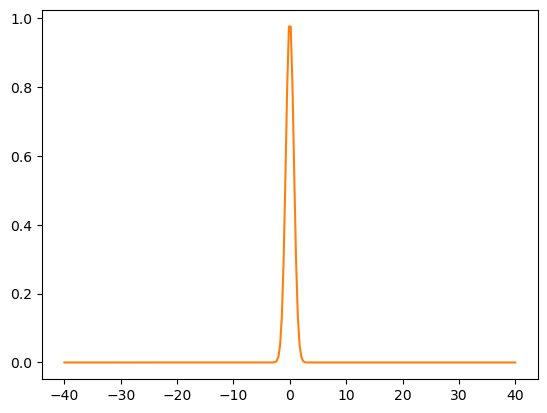

In [12]:
x = torch.linspace(-L,L,256).view(-1,1)
#
plt.figure()
exact_sol = exact_sol_f(x,0.)
plt.plot(x,exact_sol,label='exact sol',color='tab:orange')

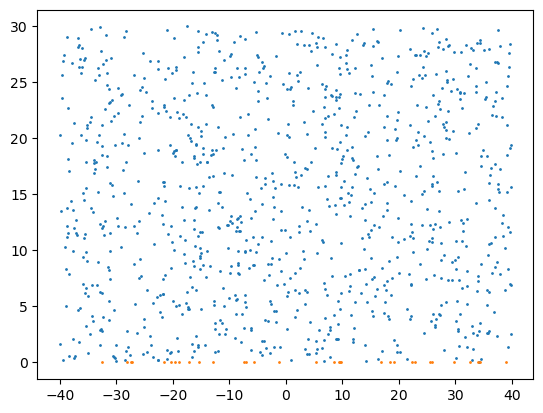

In [13]:
r,t        = random_domain_points(L,T,n=dom_points)
r_ic, t_ic = random_IC_points(L,n=ic_points)
plt.plot(r.detach().numpy(),t.detach().numpy(),'o',ms=1)
plt.plot(r_ic.detach().numpy(),t_ic.detach().numpy(),'o',ms=1)
plt.show()

In [14]:
r = r.to(device)
t = t.to(device)
#
r_ic = r_ic.to(device)
t_ic = t_ic.to(device)

In [15]:
loss_list = []
t0 = time()
# Initial training set
stop_criteria = 1.
while (stop_criteria > 0.0001):
    for epoch in range(5000):
        # Track epochs
        #if (epoch%(epochs/10)==0):
        #    print('epoch:',epoch)
        optimizer.zero_grad() # to make the gradients zero
        # RESIDUAL ################################################################   
        loss_dom = torch.mean(loss_1(r,t))
        # BC ######################################################################
        #loss_bc  =  loss_2(r_bc,t_bc)
        # IC ######################################################################
        loss_ic  = torch.mean(loss_3(r_ic,t_ic))
        # LOSS ####################################################################
        loss = loss_dom + gamma2*loss_ic
        loss_list.append(loss.cpu().detach().numpy())
        loss.backward(retain_graph=True) # This is for computing gradients using backward propagation
        optimizer.step() # 
        scheduler.step()  # Update learning rate
        if epoch % 1000 == 0:
            print(f"Epoch: {epoch} - Loss: {loss.item():>7f} - Learning Rate: {scheduler.get_last_lr()[0]:>7f}")
    # Adative sample step    
    r_,t_        = random_domain_points(L,T,n=10*dom_points)
    r_ = r_.to(device)
    t_ = t_.to(device)
    r_ic_, t_ic_ = random_IC_points(L,n=10*ic_points)
    r_ic_ = r_ic_.to(device)
    t_ic_ = t_ic_.to(device)
    #
    loss_dom_aux = loss_1(r_,t_)
    loss_ic_aux  = loss_3(r_ic_,t_ic_)   
    #
    idx_dom = torch.where(loss_dom_aux >= loss_dom_aux.sort(0)[0][-500])[0]
    idx_ic  = torch.where(loss_ic_aux >= loss_ic_aux.sort(0)[0][-50])[0]
    #
    r_aux = r_[idx_dom].view(-1,1)
    #print(r_[idx_dom])
    t_aux = t_[idx_dom].view(-1,1)
    r = torch.cat((r,r_aux),0)
    t = torch.cat((t,t_aux),0)
    #
    r_ic_aux = r_ic_[idx_ic].view(-1,1)
    t_ic_aux = t_ic_[idx_ic].view(-1,1)
    r_ic = torch.cat((r_ic,r_ic_aux),0)
    t_ic = torch.cat((t_ic,t_ic_aux),0)
    #
    stop_criteria = loss_dom_aux.sort(0)[0][-1].cpu().detach().numpy()[0]
    #
print('computing time',(time() - t0)/60,'[min]')  

Epoch: 0 - Loss: 5.021471 - Learning Rate: 0.000100
Epoch: 1000 - Loss: 0.002423 - Learning Rate: 0.000100
Epoch: 2000 - Loss: 0.000761 - Learning Rate: 0.000100
Epoch: 3000 - Loss: 0.000341 - Learning Rate: 0.000100
Epoch: 4000 - Loss: 0.000174 - Learning Rate: 0.000100
Epoch: 0 - Loss: 3.041520 - Learning Rate: 0.000100
Epoch: 1000 - Loss: 0.015393 - Learning Rate: 0.000100
Epoch: 2000 - Loss: 0.009884 - Learning Rate: 0.000100
Epoch: 3000 - Loss: 0.006225 - Learning Rate: 0.000100
Epoch: 4000 - Loss: 0.004185 - Learning Rate: 0.000100
Epoch: 0 - Loss: 0.005136 - Learning Rate: 0.000100
Epoch: 1000 - Loss: 0.003247 - Learning Rate: 0.000100
Epoch: 2000 - Loss: 0.002293 - Learning Rate: 0.000100
Epoch: 3000 - Loss: 0.001732 - Learning Rate: 0.000100
Epoch: 4000 - Loss: 0.001370 - Learning Rate: 0.000100
Epoch: 0 - Loss: 0.001700 - Learning Rate: 0.000100
Epoch: 1000 - Loss: 0.001458 - Learning Rate: 0.000100
Epoch: 2000 - Loss: 0.001068 - Learning Rate: 0.000100
Epoch: 3000 - Loss: 0.

Epoch: 1000 - Loss: 0.000011 - Learning Rate: 0.000100
Epoch: 2000 - Loss: 0.000011 - Learning Rate: 0.000100
Epoch: 3000 - Loss: 0.000011 - Learning Rate: 0.000100
Epoch: 4000 - Loss: 0.000040 - Learning Rate: 0.000100
Epoch: 0 - Loss: 0.000010 - Learning Rate: 0.000100
Epoch: 1000 - Loss: 0.000010 - Learning Rate: 0.000100
Epoch: 2000 - Loss: 0.000010 - Learning Rate: 0.000100
Epoch: 3000 - Loss: 0.000010 - Learning Rate: 0.000100
Epoch: 4000 - Loss: 0.000010 - Learning Rate: 0.000100
Epoch: 0 - Loss: 0.000012 - Learning Rate: 0.000100
Epoch: 1000 - Loss: 0.000010 - Learning Rate: 0.000100
Epoch: 2000 - Loss: 0.000011 - Learning Rate: 0.000100
Epoch: 3000 - Loss: 0.000672 - Learning Rate: 0.000100
Epoch: 4000 - Loss: 0.000013 - Learning Rate: 0.000100
Epoch: 0 - Loss: 0.000010 - Learning Rate: 0.000100
Epoch: 1000 - Loss: 0.000010 - Learning Rate: 0.000100
Epoch: 2000 - Loss: 0.000010 - Learning Rate: 0.000100
Epoch: 3000 - Loss: 0.000010 - Learning Rate: 0.000100
Epoch: 4000 - Loss:

In [30]:
450/60

7.5

In [16]:
loss_dom_aux.sort(0)[0][-1].cpu().detach().numpy()[0]

9.10922e-05

In [17]:
torch.save(model.state_dict(), 'trained_model_gpu')

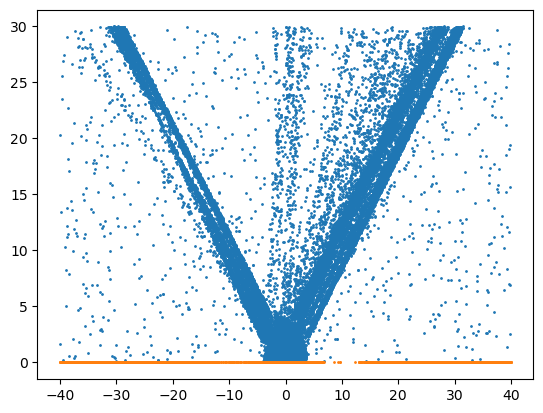

In [19]:
plt.plot(r.cpu().detach().numpy(),t.cpu().detach().numpy(),'o',ms=1)
#plt.plot(r_bc.detach().numpy(),t_bc.detach().numpy(),'o')
plt.plot(r_ic.cpu().detach().numpy(),t_ic.cpu().detach().numpy(),'o',ms=1)
#plt.show()
plt.savefig('Adaptive_sampling_gpu.png', dpi=600, facecolor=None, edgecolor=None,
            orientation='portrait', format='png',transparent=True, 
            bbox_inches='tight', pad_inches=0.1, metadata=None)

In [ ]:
#np.savez('adaptive_sampling_points',x=r.detach().numpy(),t=t.detach().numpy())

In [20]:
loss_list

[array(5.0214705, dtype=float32),
 array(4.858513, dtype=float32),
 array(4.700306, dtype=float32),
 array(4.5467973, dtype=float32),
 array(4.3978934, dtype=float32),
 array(4.2534575, dtype=float32),
 array(4.1133265, dtype=float32),
 array(3.977328, dtype=float32),
 array(3.8452864, dtype=float32),
 array(3.7170336, dtype=float32),
 array(3.5924025, dtype=float32),
 array(3.471233, dtype=float32),
 array(3.3533714, dtype=float32),
 array(3.2386754, dtype=float32),
 array(3.1270125, dtype=float32),
 array(3.0182629, dtype=float32),
 array(2.9123201, dtype=float32),
 array(2.809088, dtype=float32),
 array(2.7084835, dtype=float32),
 array(2.6104343, dtype=float32),
 array(2.5148768, dtype=float32),
 array(2.421758, dtype=float32),
 array(2.3310323, dtype=float32),
 array(2.2426598, dtype=float32),
 array(2.156607, dtype=float32),
 array(2.0728443, dtype=float32),
 array(1.991344, dtype=float32),
 array(1.9120821, dtype=float32),
 array(1.8350348, dtype=float32),
 array(1.7601786, dtyp

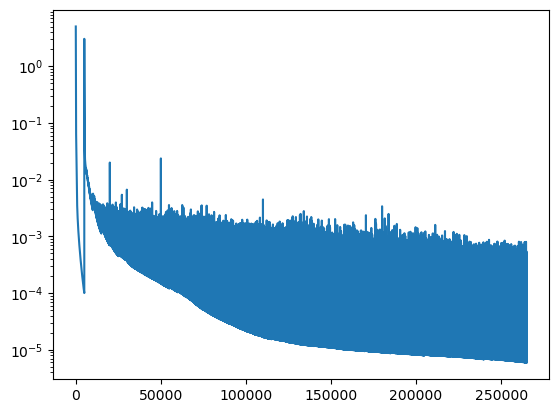

In [21]:
plt.semilogy(loss_list)

In [23]:
np.save('loss_adaptive_sampling_gpu',loss_list)

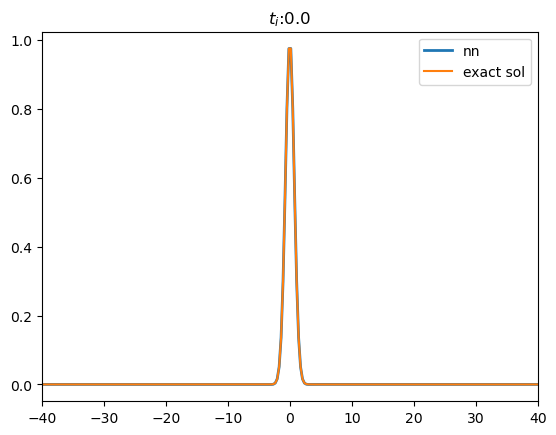

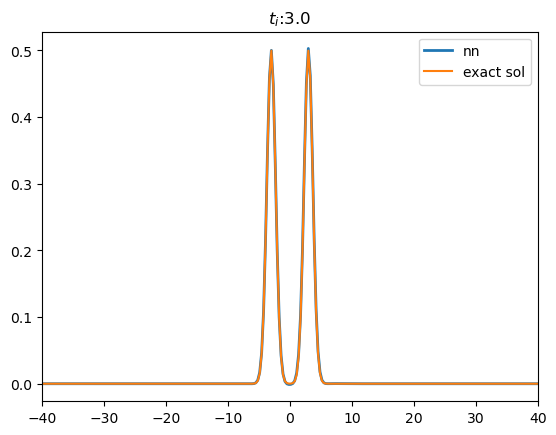

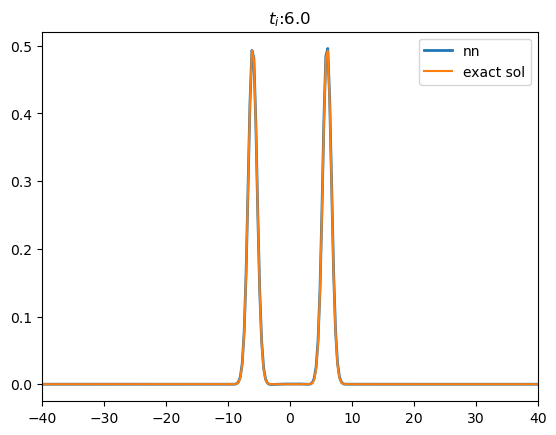

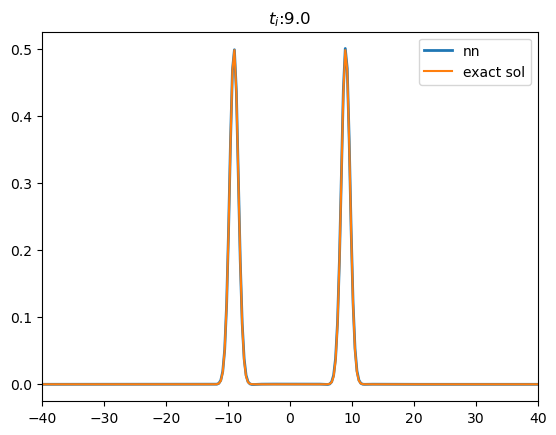

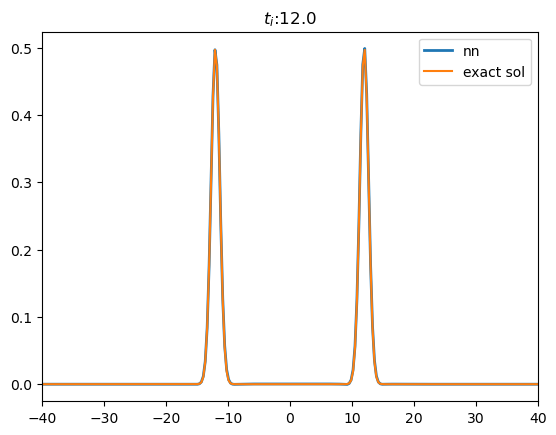

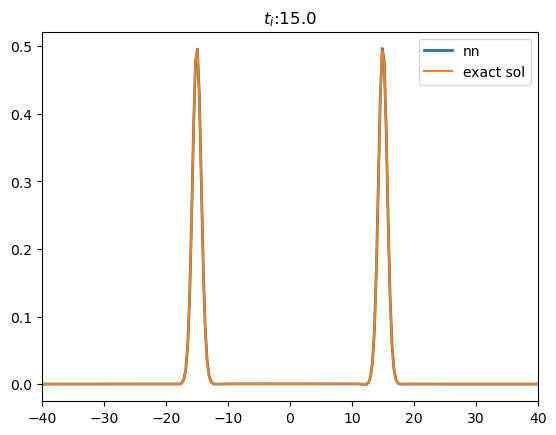

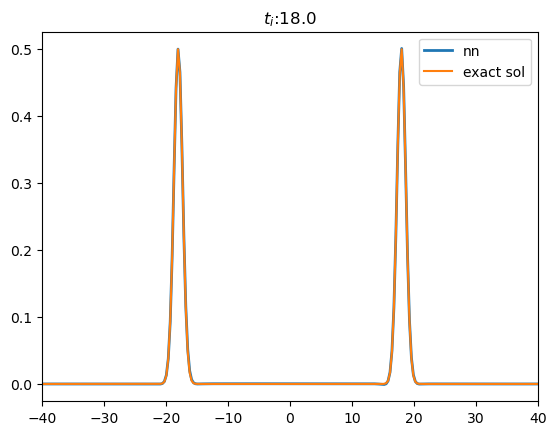

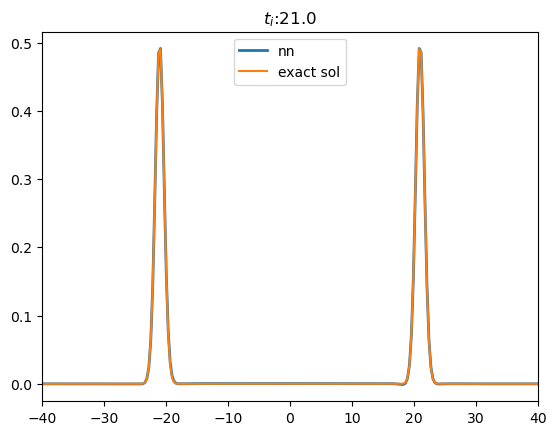

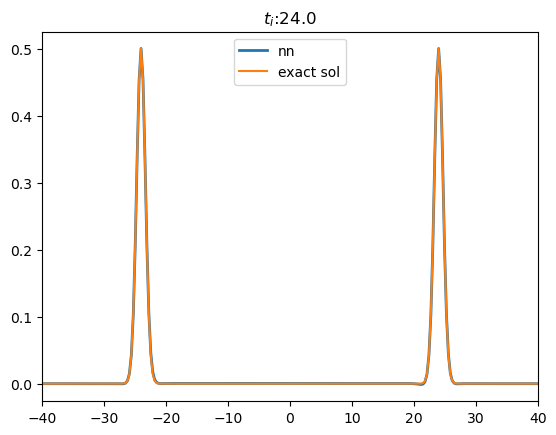

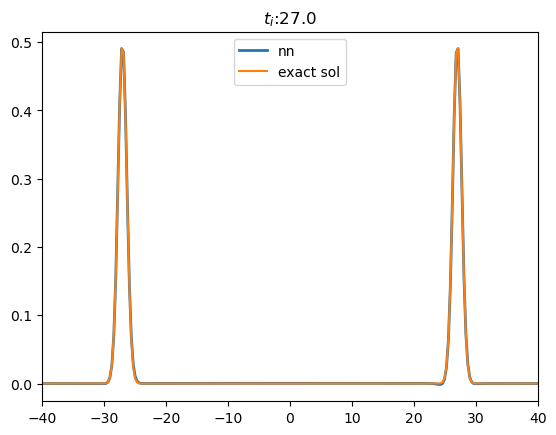

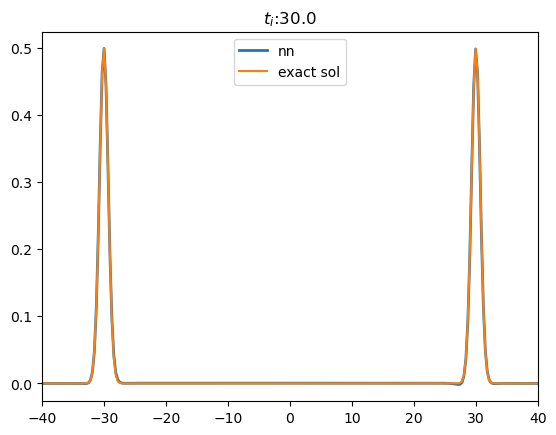

In [35]:
for t_i in np.linspace(0,T,11):
    t = t_i*torch.ones_like(x)
    t = t.to(device)
    nn_sol = model(x,t).cpu().detach().numpy()
    #
    plt.figure()
    plt.plot(x.cpu(),nn_sol,label='nn',linewidth='2')
    exact_sol = exact_sol_f(x.cpu().detach(),t_i)
    plt.plot(x.cpu(),exact_sol,color='tab:orange',label='exact sol')
    plt.title(r'$t_i$:'+str(t_i))
    plt.xlim(-L,L)
    plt.legend()

In [37]:
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

C:\Users\ignac\AppData\Local\Temp\ipykernel_8720\753016820.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


MovieWriter imagemagick unavailable; using Pillow instead.


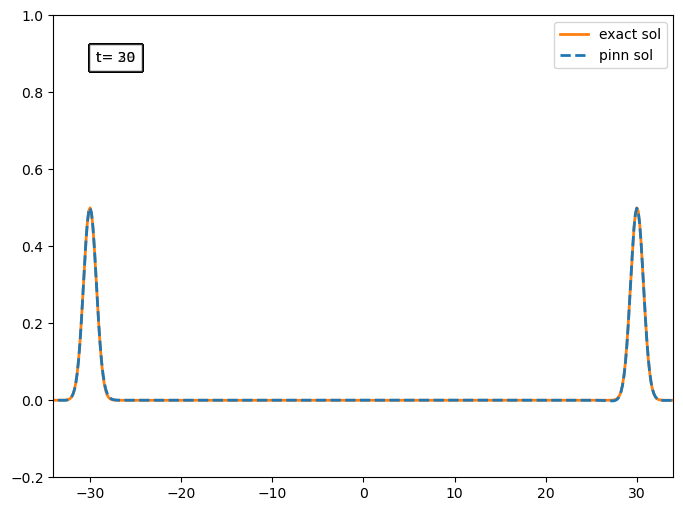

In [42]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(xlim=(-L+6, L-6), ylim=(-.2, 1.))
line1, = ax.plot([], [],
                 color='tab:orange',
                 lw=2,
                 label='exact sol'
                )
line2, = ax.plot([], [], 
                 color='tab:blue',
                 lw=2,
                 linestyle='--',
                 label='pinn sol'
                )
ax.text(0.1, 0.9, 
        "t = ", 
        bbox={'facecolor': 'white',
              'alpha': 0.5, 
              'pad': 5},
        transform=ax.transAxes, 
        ha="center")
#
ax.legend()
#
def init():
    #
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1,line2)
def animate(i):
    #####################################################
    ax.text(0.1, 0.9, 
            "t= %d" % i,
            bbox={'facecolor': 'white', 
                  'alpha': 0.5, 
                  'pad': 5},
            transform=ax.transAxes, 
            ha="center")
    #####################################################
    x_np = np.linspace(-L,L,512)
    t = i
    y_np = np.exp(-A*((x_np - x0) - c*t)**2)/2 + np.exp(-A*((x_np - x0) + c*t)**2)/2
    #####################################################
    x_tr = torch.linspace(-L,L,512).view(-1,1)
    x_tr = x_tr.to(device)
    #
    t_tr = t*torch.ones_like(x_tr)
    t_tr = t_tr.to(device)
    y_tr = model(x_tr,t_tr).cpu().detach().numpy()
    #
    line1.set_data(x_np, y_np)
    line2.set_data(x_tr.cpu().detach().numpy(), y_tr)
    return (line1,line2)

anim = FuncAnimation(fig, animate, 
                     init_func=init,
                     frames=np.linspace(0, 30, 60), 
                     blit=True
                    )
anim.save('final_wave_animation_gpu.gif', writer='imagemagick')